In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
from IPython.display import display

# Load data
data_path = 'data.xlsx'  # Update with your file path
data = pd.read_excel(data_path)

# Display the first few rows of the data
display(data.head())

# Select relevant features and the target variable
features = ['pernah_ikut_mbmk', 'pernah_mbkm_apapun', 'performa_ipk', 
            'ikut_organisasi', 'jumlah_organisasi', 'scan_ktp', 
            'upload_sertifikat', 'upload_cv', 'upload_surat_rekomendasi']
target = 'lolos_mbkm'

# Encode categorical variables
label_encoders = {}
for col in features + [target]:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

# Save encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

# Separate features and target variable
X = data[features]
y = data[target]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

print("Data preprocessing complete. Encoders and scaler saved.")


,id_data,nama,nim,jurusan,status_kemahasiswaan,pernah_ikut_mbmk,pernah_mbkm_apapun,lolos_mbkm,performa_ipk,nilai_ipk,ikut_organisasi,jumlah_organisasi,scan_ktp,upload_sertifikat,upload_cv,upload_surat_rekomendasi
0,1,Muhammad Athallah Afif,190170043,Teknik Informatika,Alumni,Belum Pernah Sama Sekali,Belum Pernah Sama Sekali,Tidak Lolos,Sangat Bagus (3.5 Hingga 4.0),3.71,Tidak Pernah,0,Ada,Tidak Ada,Ada,Tidak Ada
1,2,Kasihan Muhammad Fajar,190170066,Teknik Informatika,Semester Akhir,Sudah Pernah,Pernah,Lolos,Bagus (3.0 Hingga 3.5),"3,53",Tidak Pernah,0,Ada,Tidak Ada,Ada,Tidak Ada
2,3,Eriska Hamida Sihotang,210170169,Teknik Informatika,Mahasiswa Aktif (Sudah di semester 3 Keatas),Sudah Pernah,Belum Pernah Sama Sekali,Lolos,Sangat Bagus (3.5 Hingga 4.0),3.63,Pernah,2,Ada,Tidak Ada,Ada,Tidak Ada
3,4,Khairil Anwar,190170107,Teknik Informatika,Semester Akhir,Sudah Pernah,Pernah,Lolos,Sangat Bagus (3.5 Hingga 4.0),3.72,Pernah,2,Ada,Ada,Ada,Tidak Ada
4,5,Auza Aulia,190170145,Teknik Informatika,Semester Akhir,Sudah Pernah,Belum Pernah Sama Sekali,Tidak Lolos,Sangat Bagus (3.5 Hingga 4.0),3.6,Pernah,1,Tidak Ada,Tidak Ada,Tidak Ada,Tidak Ada


Data preprocessing complete. Encoders and scaler saved.


In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(svm_model, 'svm_model_mbkm.pkl')

print("Model training complete. Model saved.")


Model training complete. Model saved.


In [13]:
# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

y_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [26]:
# Evaluate the model
y_pred = svm_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Confusion Matrix:
[[13  0]
 [ 1  3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.75      0.86         4

    accuracy                           0.94        17
   macro avg       0.96      0.88      0.91        17
weighted avg       0.95      0.94      0.94        17


Accuracy Score:
0.9411764705882353


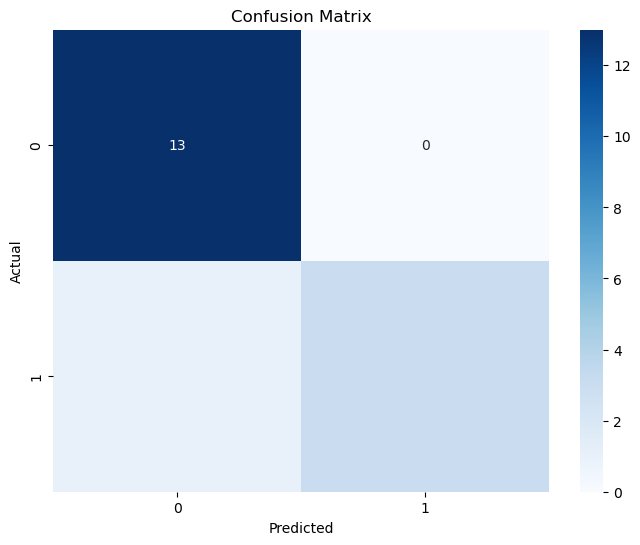

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [55]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# Load the dummy test data
test_data_path = 'test.xlsx'  # Update with your file path
test_data = pd.read_excel(test_data_path)

# Extract original data for later combination
original_test_data = test_data[['nama', 'nim', 'jurusan', 'status_kemahasiswaan']].copy()

# Drop columns that are not features
test_data = test_data.drop(columns=['nama', 'nim', 'jurusan', 'status_kemahasiswaan'])

# Load encoders and scaler
label_encoders = joblib.load('label_encoders.pkl')  # Update with your file path
scaler = joblib.load('scaler.pkl')  # Update with your file path

# Encode categorical variables using the same label encoders used in training
encoded_test_data = test_data.copy()
for col in encoded_test_data.columns:
    if col in label_encoders:
        le = label_encoders[col]
        # Handle unseen labels
        encoded_test_data[col] = encoded_test_data[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else 'Tidak Terdeteksi')

# Separate data into detected and undetected
detected_data_mask = encoded_test_data.applymap(lambda x: x != 'Tidak Terdeteksi').all(axis=1)
undetected_data_mask = ~detected_data_mask

detected_test_data = encoded_test_data[detected_data_mask]
undetected_test_data = encoded_test_data[undetected_data_mask]

# Normalize the detected data using the same scaler used in training
if not detected_test_data.empty:
    detected_test_data_scaled = scaler.transform(detected_test_data)
    # Load the trained model
    model_filename = 'svm_model_mbkm.pkl'  # Update with your file path
    svm_model = joblib.load(model_filename)
    # Make predictions
    predictions = svm_model.predict(detected_test_data_scaled)
    detected_test_data['lolos_mbkm'] = predictions
    # Decode the predictions to original labels
    detected_test_data['lolos_mbkm'] = label_encoders['lolos_mbkm'].inverse_transform(detected_test_data['lolos_mbkm'])
    detected_test_data['lolos_mbkm'] = detected_test_data['lolos_mbkm'].apply(lambda x: 'Lolos' if x == 1 else 'Tidak Lolos')

# Add 'Tidak Terdeteksi' label to undetected data
undetected_test_data['lolos_mbkm'] = 'Tidak Terdeteksi'

# Combine detected and undetected data
combined_data = pd.concat([detected_test_data, undetected_test_data], axis=0)

# Combine with original data for output
output_data = pd.concat([original_test_data.reset_index(drop=True), combined_data['lolos_mbkm'].reset_index(drop=True)], axis=1)

# Display the results
display(output_data.head())

# Save the test data with predictions
test_data_with_predictions_path = 'hasil.xlsx'  # Update with your file path
output_data.to_excel(test_data_with_predictions_path, index=False)

print(f"Predictions saved to {test_data_with_predictions_path}")


C:\Users\User\AppData\Local\Temp\ipykernel_12096\39688908.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  detected_data_mask = encoded_test_data.applymap(lambda x: x != 'Tidak Terdeteksi').all(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_12096\39688908.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detected_test_data['lolos_mbkm'] = predictions
C:\Users\User\AppData\Local\Temp\ipykernel_12096\39688908.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

,nama,nim,jurusan,status_kemahasiswaan,lolos_mbkm
0,Jarwadi Irawan,190178293,Teknik Informatika,Alumni,Tidak Lolos
1,"Cut Ciaobella Wijayanti, S.Pd",190176752,Teknik Informatika,Alumni,Tidak Lolos
2,Nadia Wijaya,190176795,Teknik Informatika,Mahasiswa Aktif (Sudah di semester 3 Keatas),Tidak Lolos
3,Sutan Kairav Tamba,190172774,Teknik Informatika,Semester Akhir,Tidak Lolos
4,Okta Purnawati,190173226,Teknik Informatika,Mahasiswa Aktif (Sudah di semester 3 Keatas),Tidak Lolos


Predictions saved to hasil.xlsx


,nama,nim,jurusan,status_kemahasiswaan,lolos_mbkm
0,Jarwadi Irawan,190178293,Teknik Informatika,Alumni,Tidak Lolos
1,"Cut Ciaobella Wijayanti, S.Pd",190176752,Teknik Informatika,Alumni,Tidak Lolos
2,Nadia Wijaya,190176795,Teknik Informatika,Mahasiswa Aktif (Sudah di semester 3 Keatas),Tidak Lolos
3,Sutan Kairav Tamba,190172774,Teknik Informatika,Semester Akhir,Tidak Lolos
4,Okta Purnawati,190173226,Teknik Informatika,Mahasiswa Aktif (Sudah di semester 3 Keatas),Tidak Lolos


Total Lolos MBKM


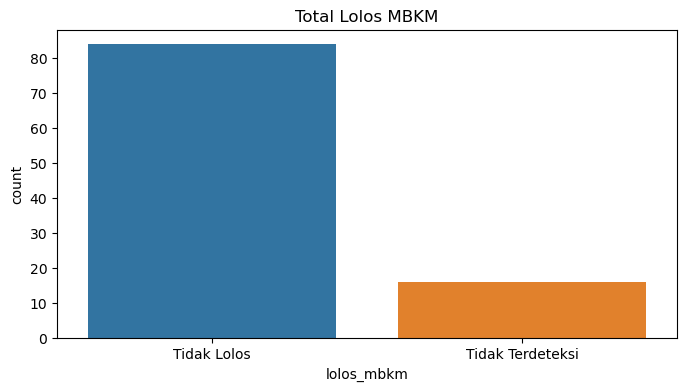

Lolos MBKM Berdasarkan Jurusan


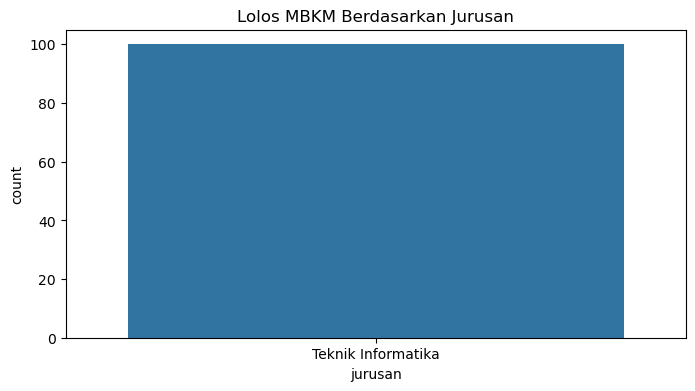

lolos_mbkm,Tidak Lolos,Tidak Terdeteksi
jurusan,,
Teknik Informatika,84,16


Lolos MBKM Berdasarkan Status Kemahasiswaan


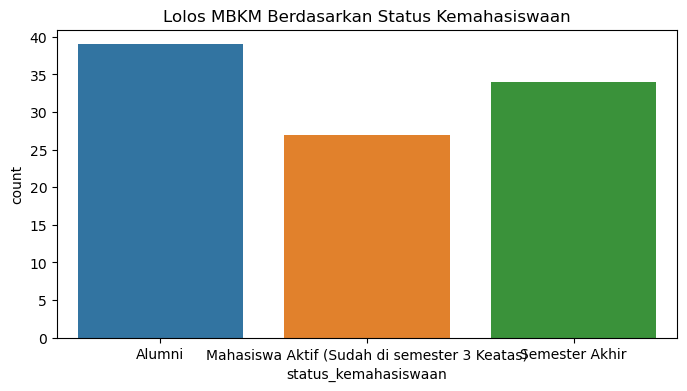

lolos_mbkm,Tidak Lolos,Tidak Terdeteksi
status_kemahasiswaan,,
Alumni,36,3
Mahasiswa Aktif (Sudah di semester 3 Keatas),23,4
Semester Akhir,25,9


Lolos/Tidak Lolos Berdasarkan Jurusan


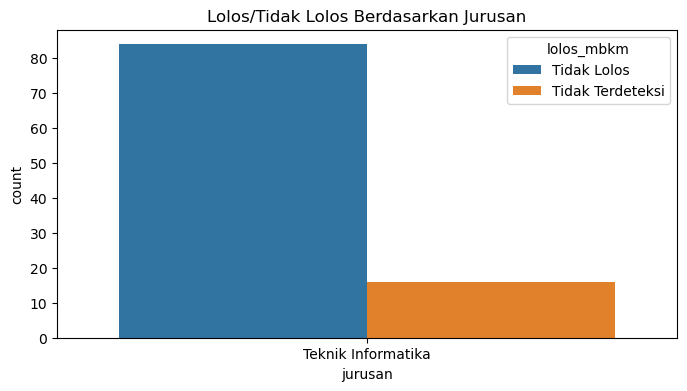

lolos_mbkm,Tidak Lolos,Tidak Terdeteksi
jurusan,,
Teknik Informatika,84,16



Skipped Plots:
Total Lolos MBKM: Grouper for 'lolos_mbkm' not 1-dimensional


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results data
output_data_path = 'hasil.xlsx'
output_data = pd.read_excel(output_data_path)

# Load the original test data
original_test_data_path = 'test.xlsx'
original_test_data = pd.read_excel(original_test_data_path)

# Display the first few rows of the output data
display(output_data.head())

# List to store skipped plots
skipped_plots = []

# Function to plot the count of categories
def plot_count(data, column, title):
    try:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=column, data=data)
        plt.title(title)
        plt.show()

        # Display the table
        if column in data.columns:
            count_data = data[[column, 'lolos_mbkm']].value_counts().unstack().fillna(0)
            display(count_data)
        else:
            raise ValueError(f"No data available for {column}")
    except Exception as e:
        skipped_plots.append(f"{title}: {e}")

# Add missing columns from the original data if necessary
columns_to_add = ['status_kemahasiswaan', 'jenis_kelamin']
for col in columns_to_add:
    if col not in output_data.columns and col in original_test_data.columns:
        output_data[col] = original_test_data[col]

# Plot the total counts
print("Total Lolos MBKM")
plot_count(output_data, 'lolos_mbkm', 'Total Lolos MBKM')

# Plot the counts by gender (if available)
if 'jenis_kelamin' in output_data.columns:
    print("Lolos MBKM Berdasarkan Jenis Kelamin")
    plot_count(output_data, 'jenis_kelamin', 'Lolos MBKM Berdasarkan Jenis Kelamin')

# Plot the counts by jurusan
print("Lolos MBKM Berdasarkan Jurusan")
plot_count(output_data, 'jurusan', 'Lolos MBKM Berdasarkan Jurusan')

# Plot the counts by status kemahasiswaan (if available)
if 'status_kemahasiswaan' in output_data.columns:
    print("Lolos MBKM Berdasarkan Status Kemahasiswaan")
    plot_count(output_data, 'status_kemahasiswaan', 'Lolos MBKM Berdasarkan Status Kemahasiswaan')

# Plot the counts of Lolos and Tidak Lolos by gender (if gender data available)
if 'jenis_kelamin' in output_data.columns:
    print("Lolos/Tidak Lolos Berdasarkan Jenis Kelamin")
    try:
        plt.figure(figsize=(8, 4))
        sns.countplot(x='jenis_kelamin', hue='lolos_mbkm', data=output_data)
        plt.title('Lolos/Tidak Lolos Berdasarkan Jenis Kelamin')
        plt.show()
        count_data = output_data[['jenis_kelamin', 'lolos_mbkm']].value_counts().unstack().fillna(0)
        display(count_data)
    except Exception as e:
        skipped_plots.append(f"Lolos/Tidak Lolos Berdasarkan Jenis Kelamin: {e}")

# Plot the counts of Lolos and Tidak Lolos by jurusan
print("Lolos/Tidak Lolos Berdasarkan Jurusan")
try:
    plt.figure(figsize=(8, 4))
    sns.countplot(x='jurusan', hue='lolos_mbkm', data=output_data)
    plt.title('Lolos/Tidak Lolos Berdasarkan Jurusan')
    plt.show()
    count_data = output_data[['jurusan', 'lolos_mbkm']].value_counts().unstack().fillna(0)
    display(count_data)
except Exception as e:
    skipped_plots.append(f"Lolos/Tidak Lolos Berdasarkan Jurusan: {e}")

# Print skipped plots
if skipped_plots:
    print("\nSkipped Plots:")
    for plot in skipped_plots:
        print(plot)
